In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Optim

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [4]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [5]:
f_in = "../trajectory/k_1_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D"); # Diffusion coefficient, unit: angstrom^2 s-1

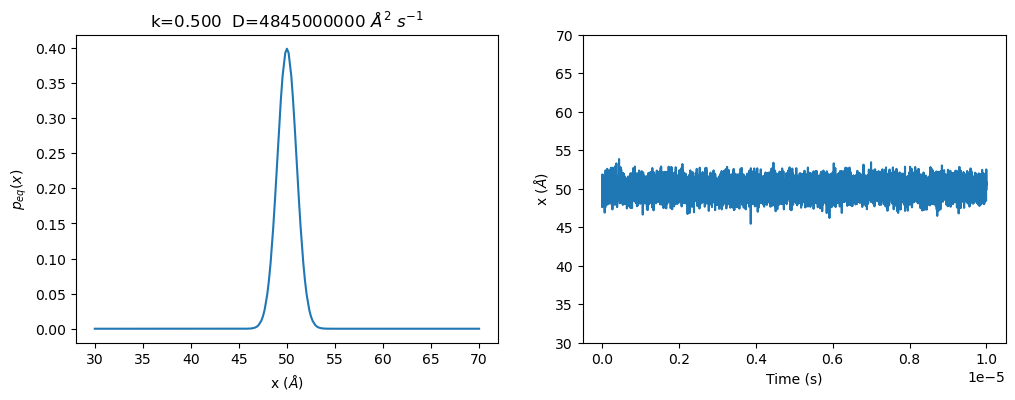

In [90]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.0f \$\\AA^2~ s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Get eigenvalues and eigenvectors

In [65]:
power_array = -2:11
n_power = length(power_array)
lambda_container = zeros(n_power, Nv)
D_array = zeros(n_power)
idx = 1
for power in power_array
    D_test = 10^(float(power))
    D_array[idx] = D_test
    Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D_test, Nv);
    lambda_container[idx, :] = Lambdas
    idx += 1
end

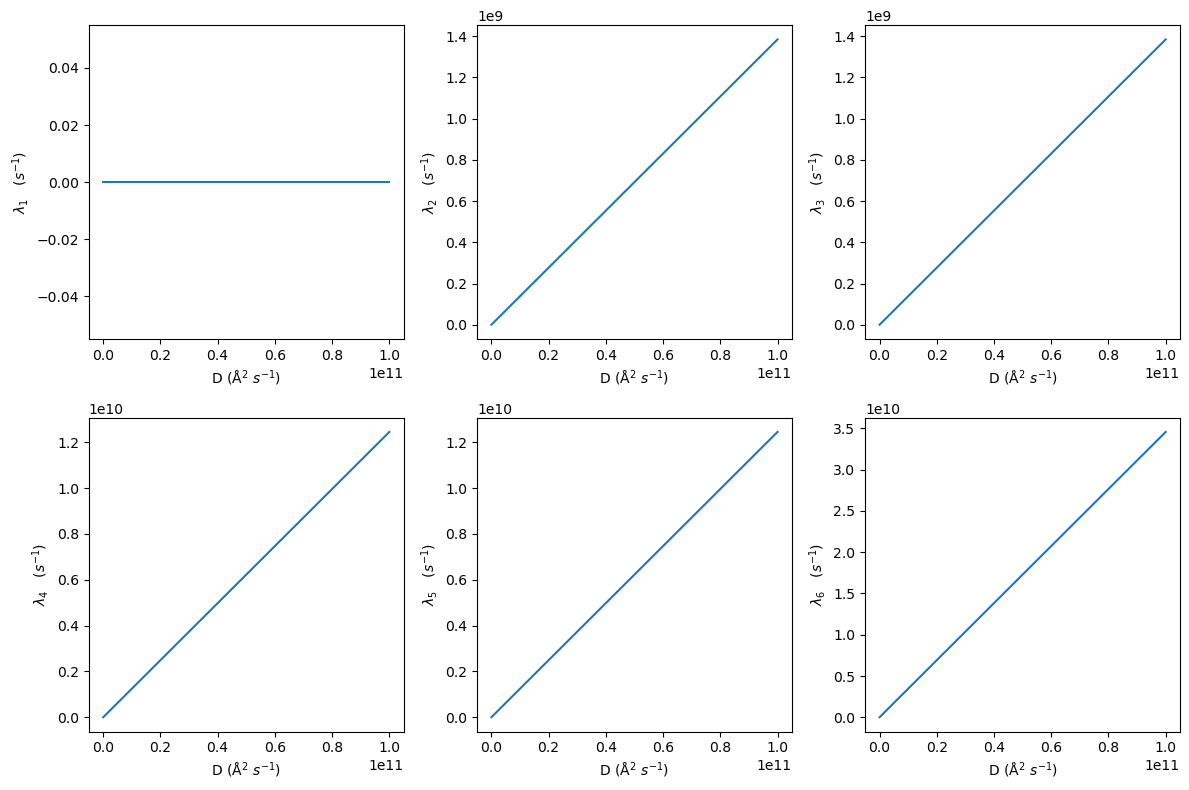

In [89]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))

idx = 1
for row_id = 1:nrows
    for col_id = 1:ncols
        ax = axes[row_id, col_id]
        ax.plot(D_array, lambda_container[:,idx])        
        ylabel = @sprintf "\$ \\lambda_{%d}~~~(s^{-1}) \$" idx
        xlabel = "D (Å\$^{2}~s^{-1}\$)"
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)        
        idx += 1
    end
end

plt.tight_layout()
#plt.savefig("eigenvalue_linear_with_D.svg")
plt.show()

### Part 5: Log-likelihood test

In [6]:
p = peq
Nv = 72
power_array = -2:11
n_power = length(power_array)
l_container = zeros(n_power,1)
D_array = zeros(n_power)
idx = 1
for power in power_array
    D_test = 10^(float(power))
    D_array[idx] = D_test   
    l_container[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p, D_test, Nv, tau, y_record, save_freq)
    idx += 1
end

In [13]:
D_answer = D
l_answer = get_loglikelihood(Nh, Np, xratio, xavg, p, D_answer, Nv, tau, y_record, save_freq);

-29970.18321287326

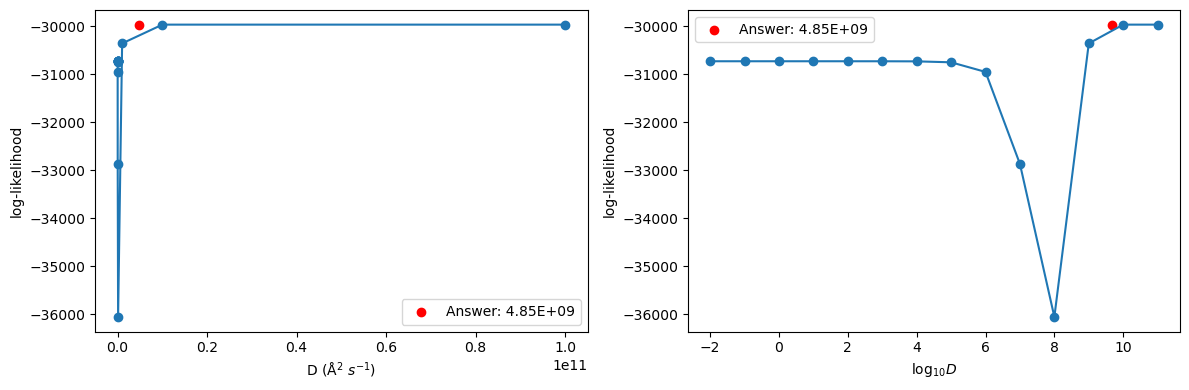

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(D_array, l_container, "-o")
label = @sprintf "Answer: %.2E" D_answer
ax.scatter(D_answer, l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D (Å\$^{2}~s^{-1}\$)")
ax.legend()

ax = axes[2]
ax.plot(log10.(D_array), l_container, "-o")
ax.scatter(log10(D_answer), l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("\$\\log_{10}D\$")
ax.legend()

plt.tight_layout()
#plt.savefig("D_loglikelihood_broad_search.svg")
plt.show()

In [26]:
multiplier_array = zeros(18)
idx = 1
for i = 1:9
    multiplier_array[idx] = i * 1e8
    idx += 1
end
for i = 1:9
    multiplier_array[idx] = i * 1e9
    idx += 1
end

In [27]:
p = peq
Nv = 72
n_multiplier = length(multiplier_array)
l_container = zeros(n_multiplier,1)
D_array = zeros(n_multiplier)
idx = 1
for D_test in multiplier_array
    D_array[idx] = D_test   
    l_container[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p, D_test, Nv, tau, y_record, save_freq)
    idx += 1
end

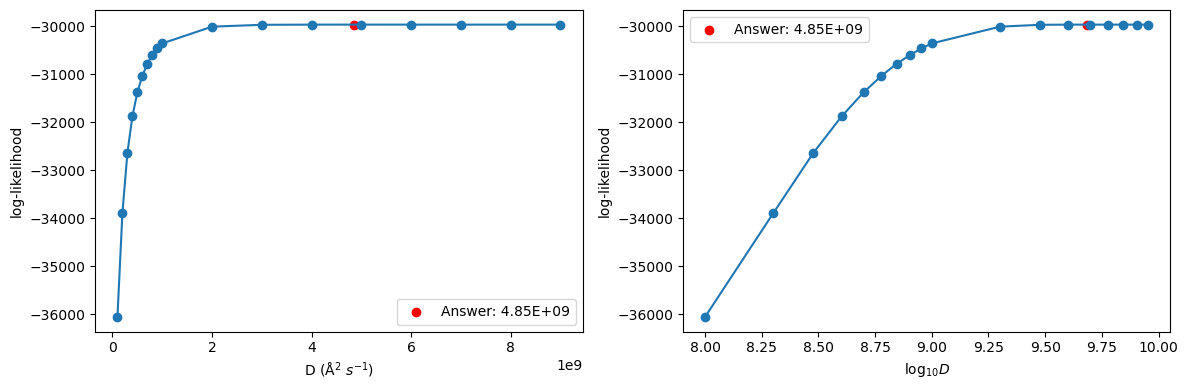

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(D_array, l_container, "-o")
label = @sprintf "Answer: %.2E" D_answer
ax.scatter(D_answer, l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D (Å\$^{2}~s^{-1}\$)")
ax.legend()

ax = axes[2]
ax.plot(log10.(D_array), l_container, "-o")
ax.scatter(log10(D_answer), l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("\$\\log_{10}D\$")
ax.legend()

plt.tight_layout()
#plt.savefig("D_loglikelihood_middle_search.svg")
plt.show()

In [35]:
multiplier_array = zeros(90)
idx = 1
for i = 10:99
    multiplier_array[idx] = (float(i) / 10.) * 1e9
    idx += 1
end

In [38]:
p = peq
Nv = 72
n_multiplier = length(multiplier_array)
l_container = zeros(n_multiplier,1)
D_array = zeros(n_multiplier)
idx = 1
for D_test in multiplier_array
    D_array[idx] = D_test   
    l_container[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p, D_test, Nv, tau, y_record, save_freq)
    idx += 1
end

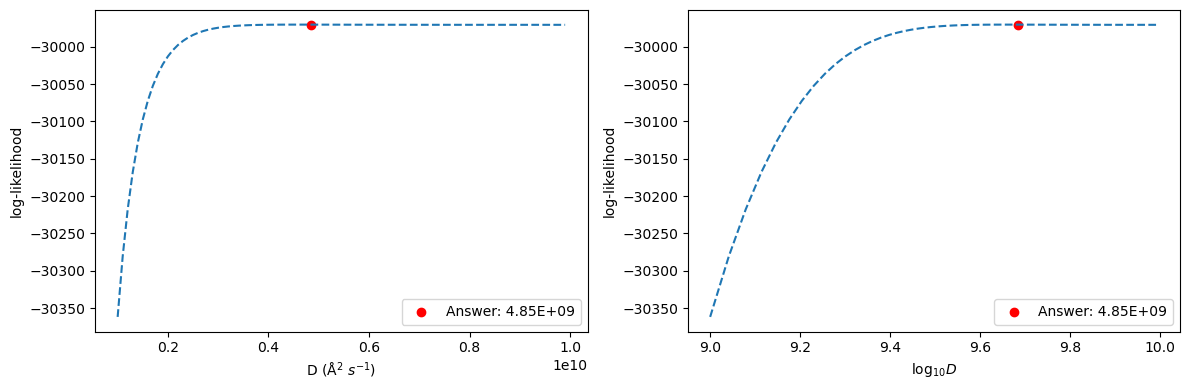

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(D_array, l_container, "--")
label = @sprintf "Answer: %.2E" D_answer
ax.scatter(D_answer, l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D (Å\$^{2}~s^{-1}\$)")
ax.legend()

ax = axes[2]
ax.plot(log10.(D_array), l_container, "--")
ax.scatter(log10(D_answer), l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("\$\\log_{10}D\$")
ax.legend()

plt.tight_layout()
#plt.savefig("D_loglikelihood_detail_search.svg")
plt.show()

### Part 6: Minimization

In [6]:
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq)

 * Status: success

 * Candidate solution
    Final objective value:     2.997045e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.09e+10 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.16e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.91e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.31e-02 ≰ 0.0e+00
    |g(x)|                 = 3.60e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   77  (vs limit Inf)
    Iterations:    1
    f(x) calls:    26
    ∇f(x) calls:   26


In [8]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 1.1931022970326258e10

In [9]:
 1.1931022970326258e10 / D

2.462543440727814

### Part 6: Load $x^{[0]}=35$ EM-100 result

In [7]:
xavg_guess = 35.
f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2.jld" xavg_guess xavg # Ad hoc
p_container = load(f_in, "p_container")
println(@sprintf "Load p_container from %s" f_in)

iter_id = 100
p_now = p_container[iter_id+1, :];

Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_35_pref_xavg_50_v2.jld


### Part 7: Plot $\frac{d p^{[k]}_{eq}(x)}{dx}$ and $\frac{d^2 p^{[k]}_{eq}(x)}{dx^2}$

In [73]:
# Add additional two more points on the tail
xref_1 = xref[:, 1]
x_test = zeros(N+2)
x_test[1:N] = xref_1[:]
x_test[N+1] = xref_1[end] + e_norm
x_test[end] = xref_1[end] + 2 * e_norm;

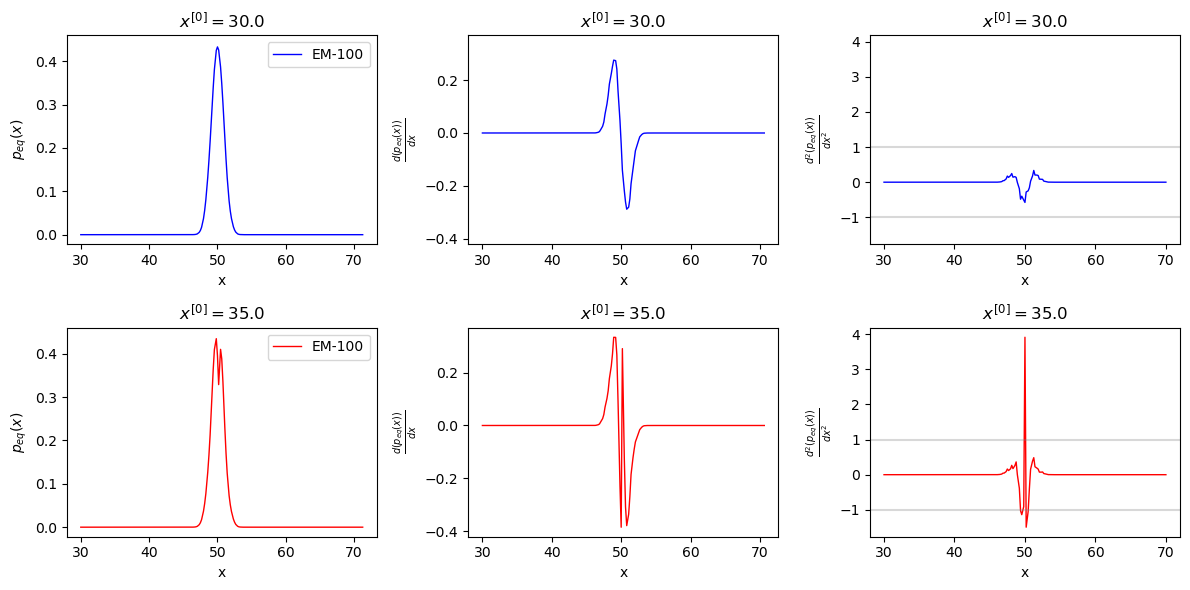

Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_30_pref_xavg_50_v2.jld
Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_35_pref_xavg_50_v2.jld


In [93]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))

xavg_guess = 30.
f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2.jld" xavg_guess xavg # Ad hoc
p_container = load(f_in, "p_container")
println(@sprintf "Load p_container from %s" f_in)
iter_id = 100
p_sele =  p_container[iter_id+1, :]
peq_revised = zeros(N+2)
peq_revised[1:N] = p_sele[:]
peq_revised[N+1] = p_sele[end]
peq_revised[end] = p_sele[end]

first_derivative = diff(peq_revised) ./ diff(x_test)
x_test_2 = x_test[1:N+1];
second_derivative = diff(first_derivative) ./ diff(x_test_2);

ax = axes[1,1]
label = @sprintf "EM-%d" iter_id
ax.plot(x_test, peq_revised, "b", lw=1, label=label)
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()
ylim = (-0.022, 0.46)
ax.set_ylim(ylim)

ax = axes[1,2]
ax.plot(x_test_2, first_derivative, "b", lw=1)
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ \\frac{d (p_{eq}(x))}{dx} \$")
ylim = (-0.421, 0.370)
ax.set_ylim(ylim)

ax = axes[1,3]
ax.plot(xref, second_derivative, "b", lw=1)
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ \\frac{d^2 (p_{eq}(x))}{dx^2} \$")
ax.axhline(1, color="grey", alpha=0.3)
ax.axhline(-1, color="grey", alpha=0.3)
ylim = (-1.766, 4.184)
ax.set_ylim(ylim)


xavg_guess = 35.
f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2.jld" xavg_guess xavg # Ad hoc
p_container = load(f_in, "p_container")
println(@sprintf "Load p_container from %s" f_in)
iter_id = 100
p_sele =  p_container[iter_id+1, :]
peq_revised = zeros(N+2)
peq_revised[1:N] = p_sele[:]
peq_revised[N+1] = p_sele[end]
peq_revised[end] = p_sele[end]

first_derivative = diff(peq_revised) ./ diff(x_test)
x_test_2 = x_test[1:N+1];
second_derivative = diff(first_derivative) ./ diff(x_test_2);

ax = axes[2,1]
iter_id = 100
label = @sprintf "EM-%d" iter_id
ax.plot(x_test, peq_revised, "r", lw=1, label=label)
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()
ylim = (-0.022, 0.46)
ax.set_ylim(ylim)

ax = axes[2,2]
label = @sprintf "EM-%d" iter_id
ax.plot(x_test_2, first_derivative, "r", lw=1)
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ \\frac{d (p_{eq}(x))}{dx} \$")
ylim = (-0.421, 0.370)
ax.set_ylim(ylim)

ax = axes[2,3]
ax.plot(xref, second_derivative, "r", lw=1)
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ \\frac{d^2 (p_{eq}(x))}{dx^2} \$")
ax.axhline(1, color="grey", alpha=0.3)
ax.axhline(-1, color="grey", alpha=0.3)
ylim = (-1.766, 4.184)
ax.set_ylim(ylim)

plt.tight_layout()
#plt.savefig("double_peak_problem_derivative.svg")
plt.show()

### Part 7: Detect Double Peak

In [95]:
abrupt_true_false, idx_abrupt = detect_abrupt(xref[:,1], p_now, N, e_norm)

(true, [94, 95, 97, 98, 99])

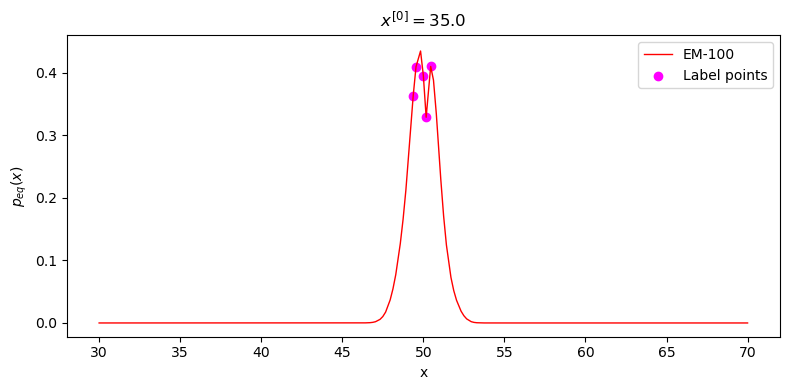

In [100]:
fig, ax = plt.subplots(figsize=(8,4))

iter_id = 100
label = @sprintf "EM-%d" iter_id
ax.plot(xref, p_now, "r", lw=1, label=label)
ax.scatter(xref[idx_abrupt], p_now[idx_abrupt], color="magenta", label="Label points")
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()
ylim = (-0.022, 0.46)
ax.set_ylim(ylim)

plt.tight_layout()
#plt.savefig("abrupt_detect.svg")
plt.show()

### Part 8: Use smoothing spline to smooth

In [8]:
smoothing_factor = 0.1
spl = Spline1D(xref[:,1], p_now; w=ones(length(xref[:,1])), k=3, bc="nearest", s=smoothing_factor)
temp = spl(xref[:,1])
p_smooth = sqrt.(temp .^ 2)
p_smooth = p_smooth / sum(w0 .* p_smooth)
p_smooth = max.(p_smooth, 1e-10)

p = zeros(N,1)
p[:,1] = p_smooth;

### Part 9: EM Test

In [11]:
# Set iteration number and initailize container
n_iteration = 100
p_container = zeros(Float64, n_iteration+1, N)
log_likelihood_records = zeros(n_iteration+1)
    
# Iteration of EM
p_prev = p
p_container[1, :] = p # The first row in container is p_0
for iter_id = 1:n_iteration
    if iter_id % 2 == 0
        print_txt = @sprintf "Position Guess at %.0f: iteration %d starts" xavg_guess iter_id
        println(print_txt)
    end
    p_em, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, p_prev, D, Nv, tau, y_record, save_freq)
    log_likelihood_records[iter_id] = log_likelihood
    p_em = max.(p_em, 1e-10)
    p_container[iter_id+1, :] = p_em
    p_prev = zeros(N,1)
    p_prev[:,1] = p_em
 end

Position Guess at 35: iteration 2 starts
Position Guess at 35: iteration 4 starts
Position Guess at 35: iteration 6 starts
Position Guess at 35: iteration 8 starts
Position Guess at 35: iteration 10 starts
Position Guess at 35: iteration 12 starts
Position Guess at 35: iteration 14 starts
Position Guess at 35: iteration 16 starts
Position Guess at 35: iteration 18 starts
Position Guess at 35: iteration 20 starts
Position Guess at 35: iteration 22 starts
Position Guess at 35: iteration 24 starts
Position Guess at 35: iteration 26 starts
Position Guess at 35: iteration 28 starts
Position Guess at 35: iteration 30 starts
Position Guess at 35: iteration 32 starts
Position Guess at 35: iteration 34 starts
Position Guess at 35: iteration 36 starts
Position Guess at 35: iteration 38 starts
Position Guess at 35: iteration 40 starts
Position Guess at 35: iteration 42 starts
Position Guess at 35: iteration 44 starts
Position Guess at 35: iteration 46 starts
Position Guess at 35: iteration 48 sta

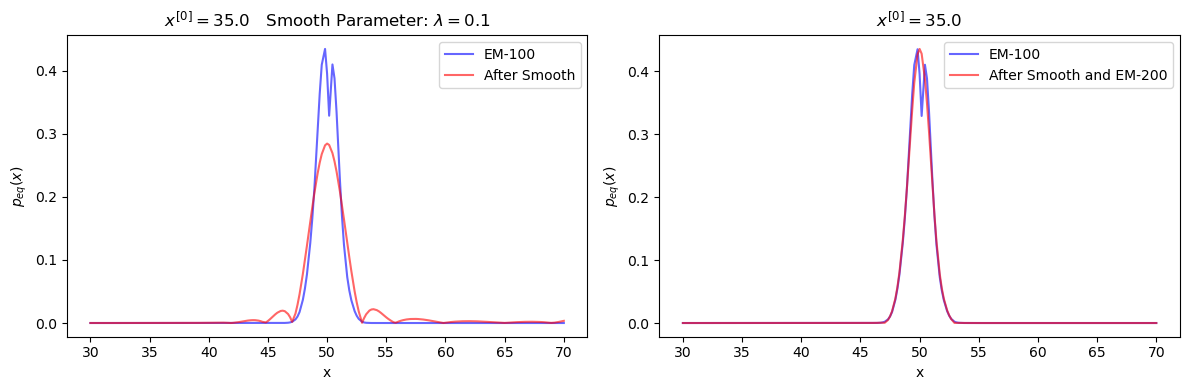

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_now, "b", lw=1.5, alpha=0.6, label="EM-100")
ax.plot(xref, p_smooth, "r", lw=1.5, alpha=0.6, label="After Smooth")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("\$p_{eq}(x)\$")
title = @sprintf "\$x^{[0]}=%.1f\$   Smooth Parameter: \$\\lambda=0.1\$" xavg_guess
ax.set_title(title)

ax = axes[2]
iter_id = 100
ax.plot(xref, p_now, "b", lw=1.5, alpha=0.6, label="EM-100")
ax.plot(xref, p_container[iter_id+1, :], "r", lw=1.5, alpha=0.6, label="After Smooth and EM-200")
ax.set_xlabel("x")
ax.set_ylabel("\$p_{eq}(x)\$")
ax.legend()
title = @sprintf "\$x^{[0]}=%.1f\$" xavg_guess
ax.set_title(title)

plt.tight_layout()
#plt.savefig("double_peak_smooth_afterEM.svg")
plt.show()

### Part 10: EM: from beginning and include detecting and smoothing

In [9]:
# Set Parameters
n_iteration = 100
mu_guess = 35.

f_out_pcontain = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_smooth.jld" mu_guess xavg
f_out_l_record = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_loglikelihood_smooth.jld" mu_guess xavg

k = 0.1 # unit: kcal/mol/angstrom^2
V = harmonic_well_k_mean(xref, k, mu_guess)
rho_guess = get_rhoeq(V, w0)
p_guess = rho_guess .* rho_guess;

In [10]:
p_container, log_likelihood_records = em_iteration(n_iteration, N, p_guess, Nh, Np, 
    xratio, xavg, D, Nv, tau, y_record, save_freq, xref, e_norm, w0, f_out_pcontain, f_out_l_record);

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Iteration-ID: 7
Iteration-ID: 8
Iteration-ID: 9
Iteration-ID: 10
Iteration-ID: 11
Iteration-ID: 12
Iteration-ID: 13
Iteration-ID: 14
Iteration-ID: 15
Iteration-ID: 16
Iteration-ID: 17
Iteration-ID: 18
Iteration-ID: 19
Iteration-ID: 20
Iteration-ID: 21
Iteration-ID: 22
Iteration-ID: 23
Iteration-ID: 24
Iteration-ID: 25
Iteration-ID: 26
Iteration-ID: 27
Iteration-ID: 28
Iteration-ID: 29
Iteration-ID: 30
Iteration-ID: 31
Iteration-ID: 32
Iteration-ID: 33
Iteration-ID: 34
Iteration-ID: 35
Iteration-ID: 36
Iteration-ID: 37
Iteration-ID: 38
Iteration-ID: 39
Iteration-ID: 40
Iteration-ID: 41
Iteration-ID: 42
Iteration-ID: 43
Iteration-ID: 44
Iteration-ID: 45
Iteration-ID: 46
Iteration-ID: 47
Iteration-ID: 48
Iteration-ID: 49
Iteration-ID: 50
Iteration-ID: 51
Iteration-ID: 52
Iteration-ID: 53
Iteration-ID: 54
Iteration-ID: 55
Iteration-ID: 56
Iteration-ID: 57
Iteration-ID: 58
Iteration-ID: 59
Iterat

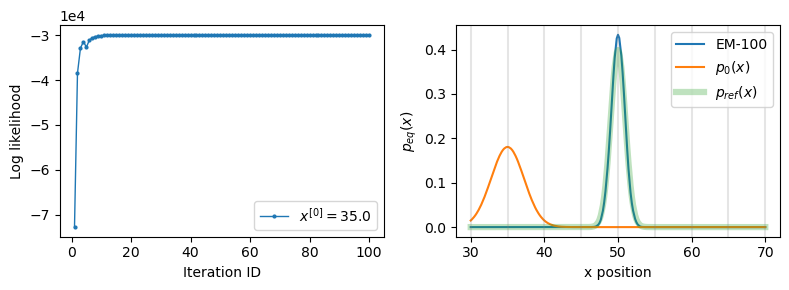

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

ax = axes[1]
n_iter = length(log_likelihood_records)-1
xarray = 1:n_iter
label = @sprintf "\$x^{[0]}=%.1f\$" mu_guess
ax.plot(xarray, log_likelihood_records[1:n_iter], "-o", linewidth=1, markersize=2, label=label)
ax.legend()
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
#ylim = (-80413.014, -27512.933)
#ax.set_ylim(ylim)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax = axes[2]
iter_id = 100
label = @sprintf "EM-%d" iter_id
ax.plot(xref, p_container[iter_id+1, :], label=label)
ax.plot(xref, rho_guess .* rho_guess, label="\$ p_0(x) \$")
ax.plot(xref, rho_eq .* rho_eq, linewidth=4.5, alpha=0.3, label="\$ p_{ref}(x) \$")
for xline in 30:5:70
    ax.axvline(xline, color="grey", alpha=0.2)
end
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

plt.tight_layout()
#plt.savefig("aftersmooth_result.svg")
plt.show()